# GradCam: Visual Explanations via Gradient-based Localization and other visualization techniques.

At the end of this lab, you will get familiarized with

*    PCA, T-SNE and Umap visualization of layer results
*   Applying GradCam for a CNN classification
*   Visualizing gradcam results

**Remember this is a graded exercise.**

*   For every plot, make sure you provide appropriate titles, axis labels, legends, wherever applicable.
*   Create reusable functions where ever possible, so that the code could be reused at different places.
*   Add sufficient comments and explanations wherever necessary.
*   **Once you have the code completed, use GPU to train model faster.**
* This lab must be worked in pairs. Make sure that when you submit your lab you change the name to: **05_lab_Student1FullName_Student2FullName.ipynb**
---

In [1]:
%%shell
git clone https://github.com/mariorot/CV-MAI
mv CV-MAI/scripts/* /content/
mv 'CV-MAI/Session 8/data_imagenet_sample' /content/
wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1KP0noUIqv9Uk5jvFPSfjyGj_zV4HbZ30' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1KP0noUIqv9Uk5jvFPSfjyGj_zV4HbZ30" -O 'CV LAB 8 - Data.zip' && rm -rf /tmp/cookies.txt
unzip 'CV LAB 8 - Data.zip'
mv 'CV LAB 8'/* /content/
unzip 'chest_xray.zip'
pip install umap-learn

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: chest_xray/train/NORMAL/IM-0522-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0523-0001-0003.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0523-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0524-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0525-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0525-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0525-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0526-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0527-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0528-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0529-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0530-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0531-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0532-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0533-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0533-0001-0002.jpeg  
  

# Exercise 1: Features extraction (1.5 points)

*In this section, we explored different techniques available to visualize via dimensionality reduction features developed through CNN models, first we train a model and extract its features. We use colorectal_histology from tfds leveraged before. Remember that this is multiclass problem with 8 possible categories.*


1**.1 First, lets build a model and assess its performance:**
*   Load "colorectal_histology" from TFDS
*   Only keep a 20% of the dataset as test set, as we will not be training the model.
*   Convert the labels to one-hot encoded form.
*   Normalize the images.

In [2]:
#solution
import tensorflow as tf
import tensorflow_datasets as tfds
from custom_plots import custom_grids
import numpy as np
from sklearn.preprocessing import LabelEncoder


test, info = tfds.load('colorectal_histology',
                       split='train[80%:]',
                       shuffle_files=True,
                       as_supervised=True,
                       with_info=True
)

test = test.shuffle(buffer_size=len(test),reshuffle_each_iteration = False)
test = test.map(lambda img, lbl: (tf.cast(img, tf.float32) / 255.0, lbl))

y = np.array(list(zip(*test))[1])

encoder = LabelEncoder()
encoder.fit(y)
encoded_y = encoder.transform(y)
y = tf.keras.utils.to_categorical(encoded_y, 8)

print(f'dataset type {type(test)} with {len(test)} images')
print(info.supervised_keys)
print(info.features.items())
print(f'\n\nNumber of features in the dataset: {len(test)}')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/5000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/colorectal_histology/2.0.0.incompleteWIEDCT/colorectal_histology-train.tfr…

Dataset colorectal_histology downloaded and prepared to /root/tensorflow_datasets/colorectal_histology/2.0.0. Subsequent calls will reuse this data.
dataset type <class 'tensorflow.python.data.ops.map_op._MapDataset'> with 1000 images
('image', 'label')
dict_items([('image', Image(shape=(150, 150, 3), dtype=uint8)), ('label', ClassLabel(shape=(), dtype=int64, num_classes=8)), ('filename', Text(shape=(), dtype=string))])


Number of features in the dataset: 1000


**1.2 Load a fine tune a MobileNet model pretrained on ImageNet**


*   Load the model `05_lab_gradcam_model_exercise1_50epochs.keras` provided to you. This was trained for 50 epochs on this dataset, starting from the Imagenet pretrained MobileNet.



In [3]:
#solution
model = tf.keras.models.load_model('lab_08_2_gradcam_model_50epochs.keras')

**1.3 Build a model to extract the features**

*   Obtain the name of the layers. Look for *global_max_pooling2d* layer, as this will be the one where we extract the features from.
*   Create a model that outputs the features from the chosen layer. Extract the intermediate features by using the predict function from the model with the test set. **Hint:** tensorflow.keras.models has a Model function that you can use to create the intermediate model. Explore its parameters






In [4]:
#solution
print(model.summary())
backbone = tf.keras.models.Model(model.input, model.get_layer('global_max_pooling2d').output)
extracted_features = backbone.predict(test.batch(len(test)))

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, None, None, 64)       9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, None, None, 64)       256       ['conv1_conv[0][0]']          
 on)                                                                                          

## Exercise 2: Feature visualization with PCA (1 point)

*Principal component analysis is a popular technique for analyzing large datasets containing a high number of dimensions by reducing dimensionality while preserving the maximum amount of information, and enabling the visualization of multidimensional data.*

*For the features extracted, apply PCA and visualize the results. Comment on what you see and the advantages of this visualization in terms of explainability.*

**2.1 Perform and visualize PCA:**

*   Flatten the feature maps in order to use them in the PCA. You can do this with the reshape function.
*   Perform PCA from sklearn.decomposition with 2 components. You can use sklearn function for this.
*   Plot the resulting 2 components, color the observations by class.



Shape of the extracted features: (1000, 2048)
Shape of the PCA transformes features: (1000, 2)


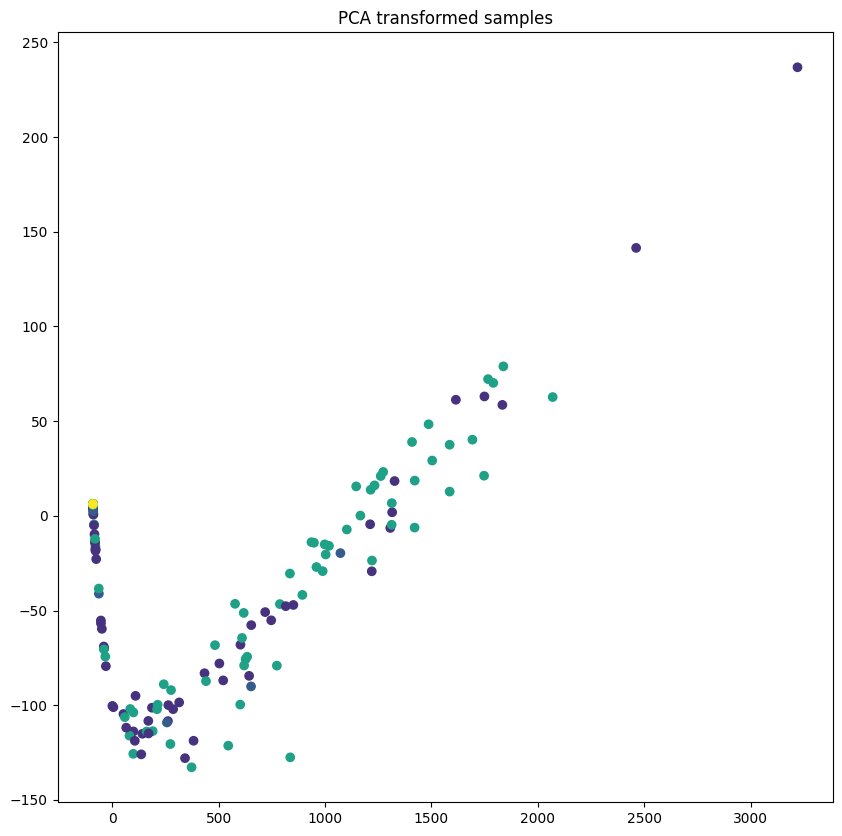

In [5]:
# solution
from sklearn.decomposition import PCA

print(f'Shape of the extracted features: {extracted_features.shape}')

pca_transformed = PCA(2).fit_transform(extracted_features)
print(f'Shape of the PCA transformes features: {pca_transformed.shape}')

cg = custom_grids([], use_grid_spec=False)
cg.show()
cg.add_plot('PCA transformed samples').scatter(pca_transformed[:,0], pca_transformed[:,1], c=encoded_y)

## Comments about the results

In the visualization of the results after applying PCA to the features extracted from the convolutional layers of the CNN it is difficult to identify clusters and patterns. The proximity of some data points in the visualization may indicate shared features, and the identification of some patterns could help to understand the underlying structure of the dataset. In this case, we cannot clearly see class separation. A clear separation in the visualization suggests that the model has learned significant features to distinguish between these classes.


In terms of the advantages of this visualization for explainability, the reduced-dimensional space offers greater interpretability compared to the original high-dimensional feature space. This facilitates a more direct understanding of the key factors influencing model decisions.

In addition, visualization helps to identify critical regions in the feature space associated with specific classes or conditions. In addition, visualization is a powerful debugging and improvement tool. If unexpected results are observed, such as samples from the same class that do not cluster, this indicates potential problems with the model that may require further investigation and refinement.

## Exercise 3: Feature visualization with T-SNE (1 point)

*In order to visualize the features of a higher dimension data, t-SNE can be used. t-SNE converts the affinities of the data points to probabilities. It recreates the probability distribution in a low-dimensional space. It is very helpful in visualizing features of different layers in a neural network.*

*You can find more information about t-SNE [here](https://scikit-learn.org/stable/modules/manifold.html#t-distributed-stochastic-neighbor-embedding-t-sne)*

**3.1 Use TSNE to visualize the features extracted from the neural network before. Obtain 2 components so you can easily visualize it in a 2-D plot, show your results**
**Hint:** TSNE function is available in the *sklearn.manifold* package.


Shape of the TSNE transformes features: (1000, 2)


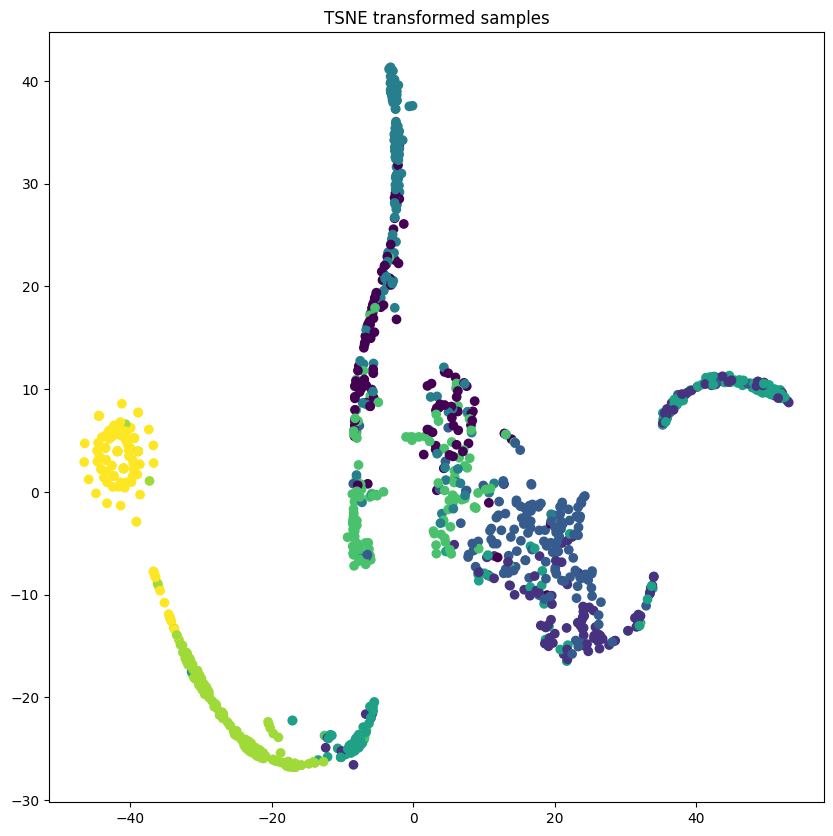

In [6]:
# solution
from sklearn.manifold import TSNE

tsne_transformed = TSNE(2).fit_transform(extracted_features)
print(f'Shape of the TSNE transformes features: {tsne_transformed.shape}')

cg = custom_grids([], use_grid_spec=False)
cg.show()
cg.add_plot('TSNE transformed samples').scatter(tsne_transformed[:,0], tsne_transformed[:,1], c=list(encoded_y))

# Exercise 4: Visualize features with UMAP (1 point)

*In this section, we will visualize different layers results via the dimensionality reduction technique UMAP (Uniform Manifold Approximation and Projection). This technique is a non-linear dimensionality reduction algorithm that preserves both local and global structures in the data. You can read more on its [paper](https://arxiv.org/abs/1802.03426)*



**4.1 Use UMAP to visualize results of last layer for the test set. Follow this steps:**
*   Apply the dimensionality reduction with umap from umap.umap_.
*   Set the model to use 5 neighbors and a minimum distance of 0.1 with euclidean as distance metric.
*   Once fitted and transform, visualize the UMAP embeddings as a scatterplot, with the classes as color. Use cmap = "tab10" inside the plt.scatter.



Shape of the UMAP transformes features: (1000, 2)


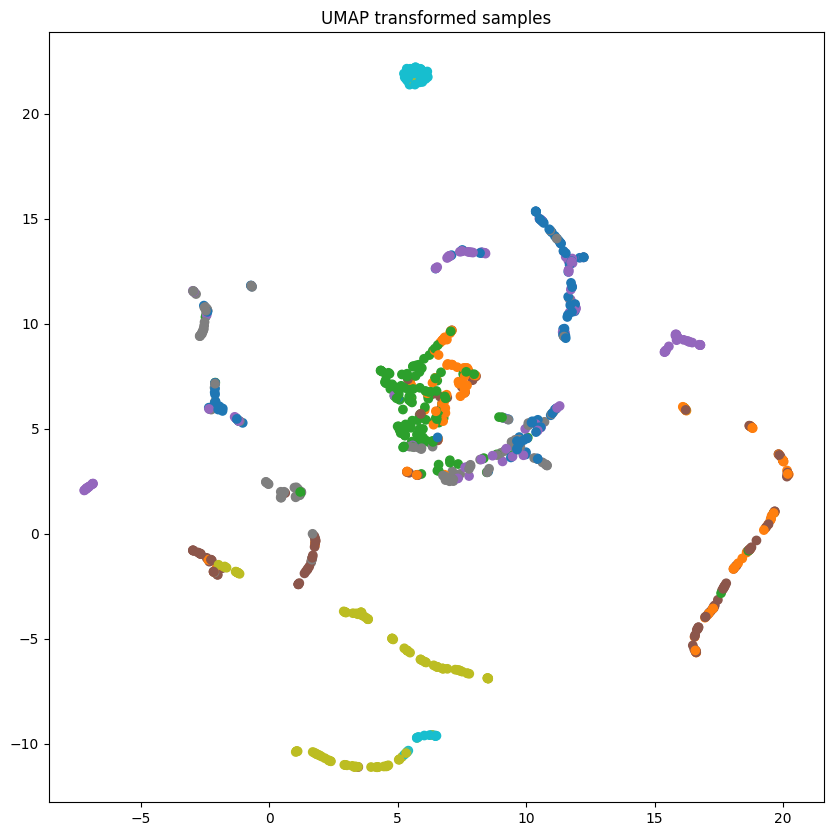

In [7]:
# solution
import umap.umap_ as umap

umap_transformed = umap.UMAP(5).fit_transform(extracted_features)
print(f'Shape of the UMAP transformes features: {umap_transformed.shape}')

cg = custom_grids([], use_grid_spec=False)
cg.show()
cg.add_plot('UMAP transformed samples').scatter(umap_transformed[:,0], umap_transformed[:,1], c=list(encoded_y), cmap="tab10")

# Exercise 5: Applying GradCam with a pre-trained model (1.5 points)

 Gradient-weighted Class Activation Mapping (Grad-CAM) is a technique to visualize CNN's class decisions. It shows a visual explanation to make a more transparent models. It allows to see where the layer is focusing on to pick a class. You can learn more about GradCam from a code perspective on [keras tutorial](https://keras.io/examples/vision/grad_cam/) and theoretical aspects from the [paper](https://arxiv.org/abs/1610.02391)

**5.1 Using a VGG16 already trained, you will apply gradcam to 5 ImageNet images provided in the folder "data_imagenet_sample".**

*   Load the VGG16. model pretrained in ImageNet. Make sure to set include_top = True in this case as we are going to use ImageNet images.
*   Look for the name of the last convolution layer. Save the name in order to plot its gradcam visualization



In [8]:
from keras.backend import clear_session
clear_session()

In [9]:
# solution
vgg16 = tf.keras.applications.VGG16()
vgg16.summary()

553467096/553467096 [==============================] - 7s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

**5.2 Explore the 5 imagenet images:**

*   Load the images provided in `data_imagenet_sample`
*   Preprocessed them, according to what the model requires. Hint: look for the preprocess function in keras.applications.vgg16 (starter code provided)
*   Predict the class for each image. Obtain the probability and label. For this, keras.applications.imagenet_utils provides a decode predictions function. A starter code for the function to do this is provided.
*   Plot the image and print both the probability and label


You can use this base code to load the images:
```python
from keras.applications.vgg16 import VGG16, preprocess_input
# Load and preprocess the ImageNet images
def load_images(folder_path, images_names):
  image_size = (224, 224)
  images = []
  # Load images
  for image_name in images_names:
    # Load
    img = image.load_img(folder_path + image_name, target_size=image_size)
    # Preprocess image
    preprocessed_img = preprocess_input(image.img_to_array(img))
    # Add to images
    images.append(preprocessed_img)
  return images

# Prediction function
def pred_model(input_batch, model):
  # Remove last layer's softmax
  model.layers[-1].activation = None
  # Get predictions for input_batch: your code should go below
  # Get decoded predictions: your code should go below
  return decoded_predictions

```


1/1 [==============================] - 0s 19ms/step


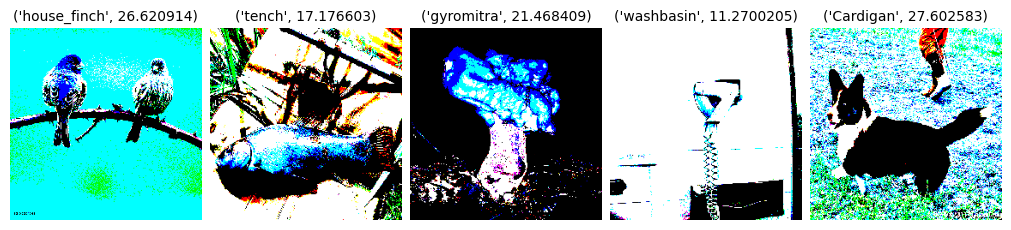

In [10]:
# solution
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.utils import load_img, img_to_array
import os

# Load and preprocess the ImageNet images
def load_images(folder_path, images_names, image_size = (224, 224)):

  images = []
  # Load images
  for image_name in images_names:
    # Load
    img = load_img(folder_path + image_name, target_size=image_size)
    # Preprocess image
    preprocessed_img = preprocess_input(img_to_array(img))
    # Add to images
    images.append(preprocessed_img)
  return images

# Prediction function
def pred_model(input_batch, model):
  # Remove last layer's softmax
  model.layers[-1].activation = None
  # Get predictions for input_batch: your code should go below
  decoded_predictions = [decode_predictions(model.predict(tf.expand_dims(ib, 0)), 1)[0][0][1:] for ib in input_batch]
  # Get decoded predictions: your code should go below
  return decoded_predictions

images = load_images('data_imagenet_sample/', os.listdir('data_imagenet_sample/'))
preds = pred_model(images, vgg16)
custom_grids(images, 1,5, preds, axis='off', title_size=10).show()

**5.3 Create the gradcam heatmap:**
*   The first step is to create a new model that maps the input image to the activations of the last convolutional layer and the output predictions.
*   Use a GradientTape to compute the gradient of the top predicted class (or a chosen class) with respect to the activations of the last convolutional layer. Use the model created as first step for this.
*   Calculate the relevance scores by taking the gradient of the output neuron (top predicted or chosen) with respect to the output feature map of the last convolutional layer.
*   Calculate a vector where each entry is the mean intensity of the gradient over a specific feature map channel. Hint: use tf.reduce_mean
*   Multiply each channel in the feature map array by its corresponding pooled gradient value to obtain the heatmap class activation.
*   For visualization purposes, normalize the heatmap values between 0 and 1. Hint: Use the functions tf.maximum and tf.math.reduce_max
* Make sure the final heatmap is a NumPy array that you can display with plt.matshow


In [11]:
# solution
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
  # Your code here
  backbone = tf.keras.models.Model(model.input, [model.get_layer(last_conv_layer_name).output, model.output])

  with tf.GradientTape() as tape:
    last_conv_layer_output, preds = backbone(tf.expand_dims(img_array, 0))
    if pred_index is None:
      pred_index = tf.argmax(preds[0])
    class_channel = preds[:, pred_index]

  print(class_channel, preds, last_conv_layer_output)

  grads = tape.gradient(class_channel, last_conv_layer_output)

  pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

  last_conv_layer_output = last_conv_layer_output[0]
  heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
  heatmap = tf.squeeze(heatmap)

  heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

  return heatmap.numpy()

**5.4 Display the heatmap for the 5 images**

tf.Tensor([26.620914], shape=(1,), dtype=float32) tf.Tensor(
[[-4.13714361e+00  4.64248085e+00 -1.07035542e+00 -4.00468063e+00
  -5.00330687e+00 -3.81767464e+00 -5.65605736e+00  4.78005075e+00
   7.44706869e+00 -1.86633420e+00  1.90434551e+01  1.70751400e+01
   2.66209145e+01  1.47127705e+01  1.53092823e+01  1.40816050e+01
   1.54323120e+01  8.59261417e+00  7.46445894e+00  1.33750534e+01
   1.25330305e+01  9.56332016e+00  2.02017021e+00  4.10293341e+00
   6.65898609e+00 -2.31871629e+00  1.07710874e+00 -2.84823626e-02
  -2.00077581e+00 -1.53618944e+00 -1.30486333e+00  1.09367633e+00
   1.53572702e+00 -1.01624119e+00 -1.76398826e+00 -2.91972065e+00
   1.16163123e+00 -1.35773921e+00 -9.09025371e-01 -6.46513477e-02
   5.85138750e+00  3.31674957e+00  4.52296925e+00  7.79919267e-01
  -1.40633368e+00 -7.01835155e-01  1.52881280e-01  2.70684552e+00
  -4.33020163e+00 -4.24691629e+00 -2.61418414e+00 -5.60685968e+00
   3.43428135e-01  2.30759144e-01 -9.88167167e-01  1.13187216e-01
  -1.73786175e+

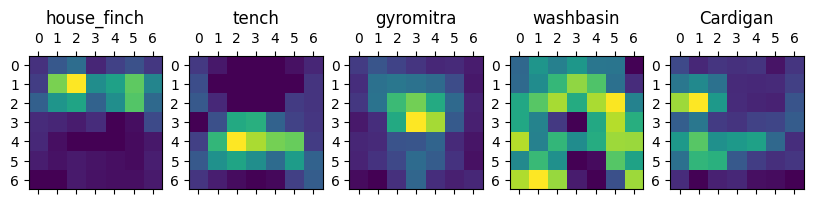

In [12]:
# solution
# Generate class activation heatmaps
heatmaps = [make_gradcam_heatmap(i, vgg16, 'block5_pool') for i in images]

# Display heatmaps
cg = custom_grids([],1,5, axis='off', use_grid_spec=False)
cg.show()
for i,h in enumerate(heatmaps):
  cg.add_plot(preds[i][0]).matshow(h)

**5.5 Display a superimposed visualization of the 5 images:**

Create a function that does the following:
*   Rescale the heatmap values to the range of 0-255 and use the "jet" colormap to colorize the heatmap. Use the cm.get_cmap function
*   Convert the colorized heatmap to a PIL (Python Imaging Library) image, resize it to the dimensions of the original input image, and convert it back to a NumPy array.
*   Blend the colorized heatmap with the original image using the specified alpha value. Alpha should be a value that can be determined to set the transparency of the heatmap. This looks something like this: jet_heatmap * alpha + img. Then apply keras.utils.array_to_img to the result. This will create the superimposed image to be plotted with plt.imshow



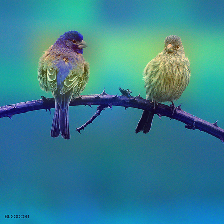

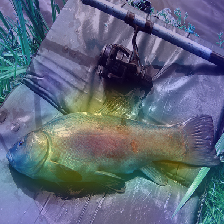

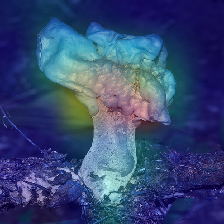

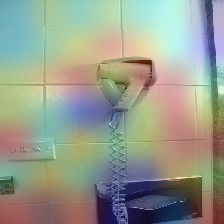

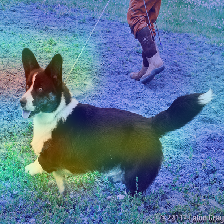

In [13]:
# solution
import matplotlib as mpl

def display_gradcam(img, heatmap, alpha=0.4):
  heatmap = np.uint8(255 * heatmap)

  # The cm.get_cmap function was deprecated in Matplotlib 3.7
  jet = mpl.colormaps["jet"]

  jet_colors = jet(np.arange(256))[:, :3]
  jet_heatmap = jet_colors[heatmap]

  jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap)
  jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
  jet_heatmap = tf.keras.utils.img_to_array(jet_heatmap)

  superimposed_img = jet_heatmap * alpha + img
  superimposed_img = tf.keras.utils.array_to_img(superimposed_img)

  return superimposed_img

for i,h in zip(images, heatmaps):
  display(display_gradcam(i,h))

# Exercise 6: Apply GradCam to with Chest X-ray images dataset (3 points)

*You have used this dataset in the last lab, it contains 5,863 Chest X-Ray images classified into 2 categories (Pneumonia/Normal). The normal chest X-ray shows clear lungs without any areas of abnormal opacification in the image. Bacterial pneumonia typically exhibits a focal lobar consolidation, whereas viral pneumonia manifests with a more diffuse ‘‘interstitial’’ pattern in both lungs.*



A code to load the data and print a couple of images is provided.

In [14]:
from keras.backend import clear_session
clear_session()
from tensorflow.keras.preprocessing.image import ImageDataGenerator
input_shape = (128, 128, 3)
batch_size = 32
n_classes = 2

folder_path_ex6 = "/content/chest_xray"

# Define the paths to your train, test, and validation directories
train_dir = folder_path_ex6 + '/train'
test_dir = folder_path_ex6 + '/test'
val_dir = folder_path_ex6 + '/val'

# Define the parameters for data augmentation and normalization
batch_size = 64
image_size = (128, 128)

# Create an instance of the ImageDataGenerator and set the preprocessing options
datagen = ImageDataGenerator(rescale=1.0/255)

# Load and preprocess the training data
train_ds = datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

# Load and preprocess the test data
test_ds = datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

# Load and preprocess the validation data
valid_ds = datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

# Get the class indices from the flow_from_directory output
class_indices = train_ds.class_indices

# Class names
class_names = {v: k for k, v in class_indices.items()}


Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


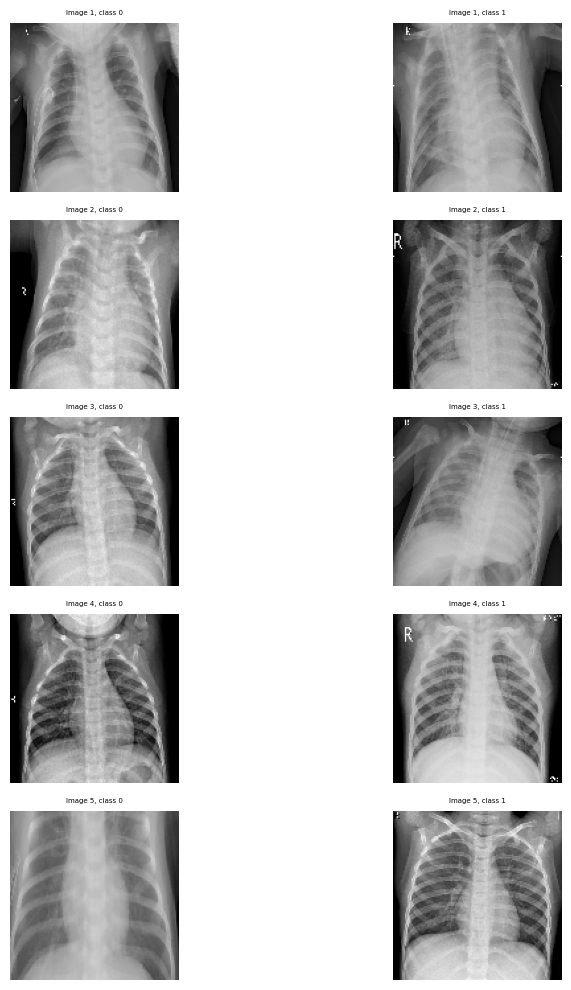

In [15]:
import matplotlib.pyplot as plt
# Printing 5 images
n_samples = 5
idx = {}

# Getting index per each class
for number in range(n_classes):
    indices = np.where(train_ds.classes == number)[0][:n_samples]
    idx[number] = indices

# Plotting
fig, axes = plt.subplots(n_samples, n_classes, figsize=(10, 10))

for class_i, indices in idx.items():
    for id, idx in enumerate(indices):
        batch_x, batch_y = train_ds[idx // batch_size]
        image = batch_x[idx % batch_size]
        axes[id, class_i].imshow(image, cmap=plt.get_cmap('gray'))
        axes[id, class_i].set_title(f'Image {id+1}, class {class_i}', fontsize=5)
        axes[id, class_i].axis('off')

plt.tight_layout()
plt.show()


**2.2 Apply GradCam to train models. For this consider:**
*  We are providing you with 2 models `05_lab_gradcam_model_10epochs.keras` and `05_lab_gradcam_model_25epochs.keras`. One was trained for 10 epochs and the other one for 25 epochs with a ResNet50. Load them into your environment.



In [16]:
#solution
mods = {'10':tf.keras.models.load_model('lab_08_2_gradcam_model_10epochs.keras'),
        '25':tf.keras.models.load_model('lab_08_2_gradcam_model_25epochs.keras')}

**2.3 Obtain your gradcam visualization for `both` models:**
* Obtain the gradcam superimposed visualization for 5 images. Choose the last convolutional layer to do this.
* Also print the actual and predicted class
* Comment on the results - which one you think is making more sense?


In [17]:
mods['10'].summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 134, 134, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 64, 64, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 64, 64, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [18]:
# solution
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
  # Your code here
  backbone = tf.keras.models.Model(model.input, [model.get_layer(last_conv_layer_name).output, model.output])

  with tf.GradientTape() as tape:
    last_conv_layer_output, preds = backbone(tf.expand_dims(img_array, 0))
    if pred_index is None:
      pred_index = tf.argmax(preds[0])
    class_channel = preds[:, pred_index]

  print(class_channel, preds, last_conv_layer_output)
  grads = tape.gradient(class_channel, last_conv_layer_output)


  pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

  last_conv_layer_output = last_conv_layer_output[0]
  heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
  heatmap = tf.squeeze(heatmap)

  heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

  return heatmap.numpy()

In [ ]:
sample

In [19]:
images = load_images('/content/chest_xray/train/PNEUMONIA/', os.listdir('/content/chest_xray/train/PNEUMONIA')[:5], (128,128))

heatmaps = [make_gradcam_heatmap(i, model, 'conv5_block3_out') for i in images]

tf.Tensor([0.5707732], shape=(1,), dtype=float32) tf.Tensor(
[[0.00470216 0.33728832 0.0333715  0.00247901 0.5707732  0.02163448
  0.01796068 0.01179074]], shape=(1, 8), dtype=float32) tf.Tensor(
[[[[     0.          0.          0.     ...      0.      58064.906
         0.    ]
   [     0.          0.          0.     ...      0.      96664.016
      6695.328 ]
   [     0.          0.          0.     ...      0.     110343.27
     20374.703 ]
   [     0.          0.          0.     ...      0.      80196.77
     20131.316 ]]

  [[     0.          0.          0.     ...      0.      82764.66
         0.    ]
   [     0.          0.          0.     ...      0.     138673.75
         0.    ]
   [     0.          0.          0.     ...      0.     157007.03
         0.    ]
   [     0.          0.          0.     ...      0.     117395.33
         0.    ]]

  [[     0.          0.          0.     ...      0.      77564.17
         0.    ]
   [     0.          0.          0.     ...      0.

In [20]:
heatmaps

[array([[nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan]], dtype=float32),
 array([[nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan]], dtype=float32),
 array([[nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan]], dtype=float32),
 array([[nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan]], dtype=float32),
 array([[nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan]], dtype=float32)]

In [39]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = tf.keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = tf.keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(tf.expand_dims(img_array, 0))
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap, top_pred_index.numpy()

In [40]:
images = load_images('/content/chest_xray/train/PNEUMONIA/', os.listdir('/content/chest_xray/train/PNEUMONIA')[:5], (128,128))

heatmaps = [make_gradcam_heatmap(i, model, 'conv5_block3_out', ['flatten', 'dense', 'dense_1', 'dense_2']) for i in images]

<ipython-input-39-d997c55291a4>:46: RuntimeWarning: invalid value encountered in divide
  heatmap = np.maximum(heatmap, 0) / np.max(heatmap)


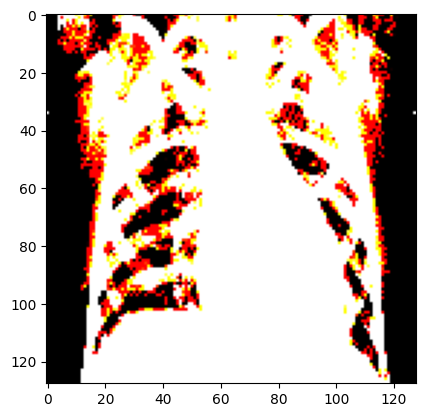

In [46]:
plt.imshow(images[0])

In [48]:
heatmaps[0]

(array([[nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan]], dtype=float32),
 0)

In [44]:
display(display_gradcam(images[0],heatmaps[0]))

ValueError: ignored


Model trained 10 epochs



<ipython-input-39-d997c55291a4>:46: RuntimeWarning: invalid value encountered in divide
  heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_axes.py:7973: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Z = np.asanyarray(Z)


TypeError: ignored

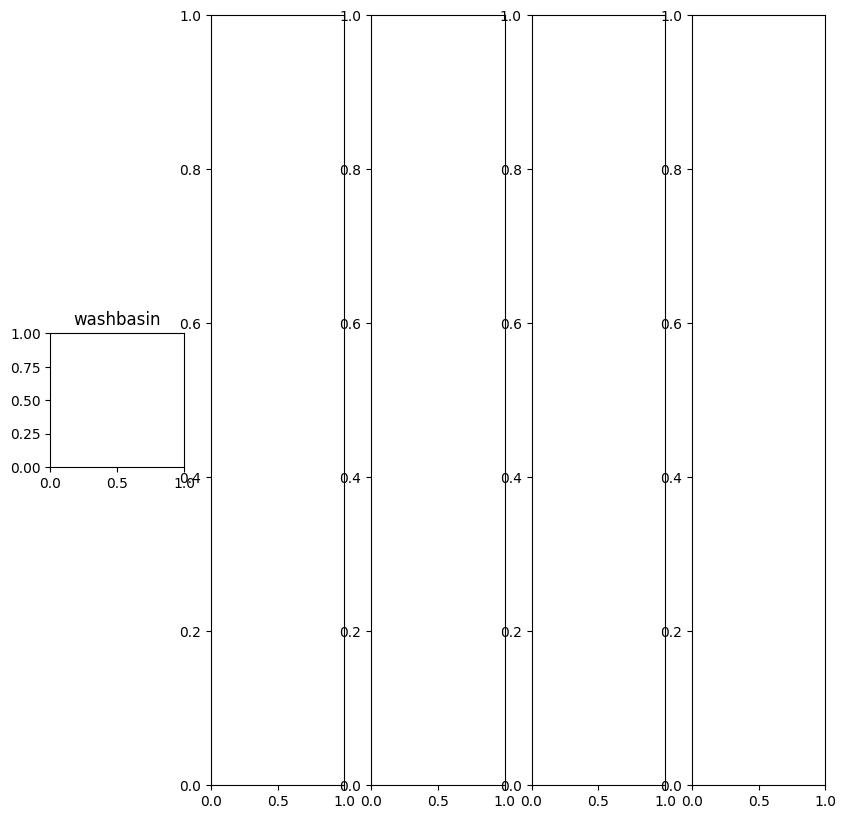

In [41]:
#solution

images = load_images('/content/chest_xray/test/PNEUMONIA/', os.listdir('/content/chest_xray/test/PNEUMONIA')[:5], (128,128))

for k, model in mods.items():
  # clear_session()
  print(f"\nModel trained {k} epochs\n")
  heatmaps = [make_gradcam_heatmap(i, model, 'conv5_block3_out', ['flatten', 'dense', 'dense_1', 'dense_2']) for i in images]

  cg = custom_grids([],1,5, axis='off', use_grid_spec=False)
  cg.show()
  for i,h in enumerate(heatmaps):
    cg.add_plot(preds[i][0]).matshow(h)

  for i,h in zip(images, heatmaps):
    display(display_gradcam(i,h))

Comment on the differences:

**SOLUTION**



---

# **End of Lab 04: Interpretation with GradCAM**